In [5]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [137]:
class Gibbs_Sampling_poisson_mixture():
    def __init__(self, lambda_ini, pi_ini, a_ini, b_ini, alpha_ini, N, K): # N:入力データ数, K:クラス数(2)
        self.lambda_ = lambda_ini
        self.pi = pi_ini
        self.a = a_ini
        self.b = b_ini
        self.alpha = alpha_ini
        self.N = N
        self.K = K
        
        self.s = np.zeros((N, K))

    # s_nをサンプリング
    def sampling_s(self, x, n):      
        eta = np.zeros(self.K) # 必要？
        eta = np.exp(x[n]*np.log(self.lambda_) - self.lambda_ + np.log(self.pi))
        eta = eta / np.sum(eta) # 規格化
        
        xk = np.arange(self.K)
        custm = stats.rv_discrete(name='custm', values=(xk, eta)) # カテゴリ分布を定義
        
        s = np.zeros(self.K)
        k = custm.rvs() # custm.rvs()は離散変数のインデクスを出力 exp:0,1,2
        s[k] = 1 # ワンホットに変換
        
        return s
    
    # lambda_kをサンプリング
    def sampling_lambda(self, x, k):
        # a_kを計算
        tmp = 0
        for n in range(self.N):
            tmp += self.s[n, k]*x[n]
        ak_esti = tmp + self.a
            
        # b_kを計算
        tmp = 0
        for n in range(self.N):
            tmp += self.s[n, k]
        bk_esti = tmp + self.b
        
        g = stats.gamma(a=ak_esti, scale=1.0/bk_esti) # ガンマ分布を定義 尺度母数:scale=1/b 
        
        return g.rvs()
    
    # piをサンプリング
    def sampling_pi(self):
        # alphaを計算
        alpha_esti = np.zeros(self.K)
        for k in range(self.K):
            tmp = 0
            for n in range(self.N):
                tmp += self.s[n, k]
            alpha_esti[k] = tmp + self.alpha[k]
            
        d = stats.dirichlet(alpha=alpha_esti) # ディリクレ分布を定義
        
        return (d.rvs())[0]
    
    def gibbs_sampling(self, x):
        lambda_old = 0
        for i in range(50):
            for n in range(self.N):
                self.s[n] = self.sampling_s(x, n)
            for k in range(self.K):
                self.lambda_[k] = self.sampling_lambda(x, k)
            self.pi = self.sampling_pi()
            
    def get_lambda(self):
        return self.lambda_
    def get_pi(self):
        return self.pi

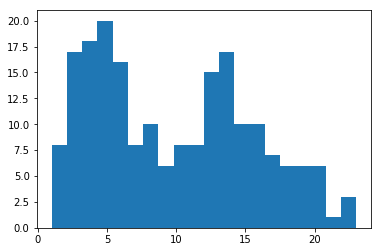

[ 4.39605237 13.44548092] [0.42877906 0.57122094]


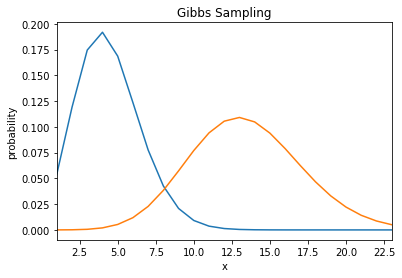

In [146]:
# 平均 50, 標準偏差 10 の正規乱数を1,000件生成
x1 = stats.poisson(5).rvs(100)
# 平均 80, 標準偏差 6 の正規乱数を1,000件生成
x2 = stats.poisson(15).rvs(100)
x = np.hstack((x1, x2)) # 連結

# ヒストグラムを出力
plt.hist(x, bins=20)
plt.show()

g = Gibbs_Sampling_poisson_mixture(np.array([10.0, 10.0]), np.array([0.5, 0.5]), 1., 1., np.array([1., 1.]), x.size, 2)

g.gibbs_sampling(x)

print(g.get_lambda(), g.get_pi())
    
# 求めた平均と混合比率を用いてポアソン分布を定義
p1 = stats.poisson((g.get_lambda())[0])
p2 = stats.poisson((g.get_lambda())[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('x')             # x軸ラベル
ax.set_ylabel('probability')   # y軸ラベル
ax.set_title("Gibbs Sampling") # グラフタイトル

x_ary = np.arange(25)
plt.xlim(np.min(x), np.max(x))
plt.plot(x_ary, p1.pmf(x_ary), label="poisson1")
plt.plot(x_ary, p2.pmf(x_ary), label="poisson2")
plt.show()